# LSST software stack demo
- Goal: isolate extended low-surface-brightness sources

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

%matplotlib inline
import matplotlib.pyplot as plt

from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

In [3]:
butler = dafPersist.Butler("/Volumes/RHLData/hsc-v13_0")

In [4]:
def smooth_gauss(masked_image, sigma, nsigma=1.0):
    width = (int(sigma*nsigma + 0.5) // 2)*2 + 1
    gauss_func = afwMath.GaussianFunction1D(sigma)
    gauss_kern = afwMath.SeparableKernel(width, width, gauss_func, gauss_func)
    convolved_image = masked_image.Factory(masked_image.getBBox())
    afwMath.convolve(convolved_image, masked_image, gauss_kern, 
                     afwMath.ConvolutionControl())
    return convolved_image

def display_image(image, figsize=(15,5)):
    fig, ax = plt.subplots(figsize=figsize)
    vmin, vmax = zscale.get_limits(image)
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray_r', 
              aspect='equal', origin='lower')
    ax.axis('off')
    return ax

## Get HSC calibrated exposure

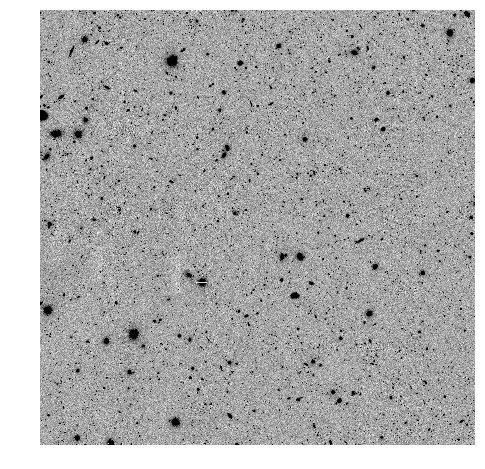

In [5]:
dataId = dict(tract=9348, patch='7,6', filter='HSC-I')
exp = butler.get('deepCoadd_calexp',dataId)
display_image(exp.getMaskedImage().getImage().getArray(), figsize=(8,8));

# Make cutout

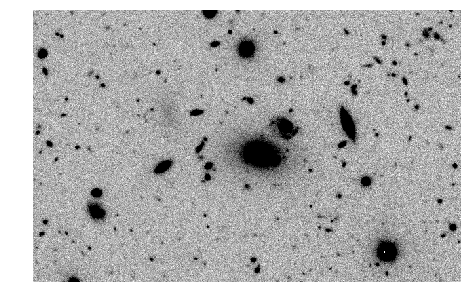

In [6]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(2700, 3600))
bbox.include(afwGeom.Point2I(3330, 4000))
exp_cutout = exp.Factory(exp, bbox, afwImage.LOCAL)

mi = exp_cutout.getMaskedImage()
mask = mi.getMask()
mask.removeAndClearMaskPlane('CR', True)

display_image(mi.getImage().getArray());

# Smooth at PSF scale

In [7]:
psf = exp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
ngrow = int(3*sigma)
mi_smooth = smooth_gauss(mi, sigma)
print('psf fwhm = {:.2f} arcsec'.format(sigma*0.168*2.355))

psf fwhm = 0.52 arcsec


# Image thresholding
- Find high-threshold sources that are 6 $\sigma$ above the background and create a mask plane

In [8]:
high_thresh = 6
fpset_high = afwDetect.FootprintSet(
    mi_smooth, afwDetect.Threshold(high_thresh, afwDetect.Threshold.STDEV), 'HIGH_THRESH', 1)
fpset_high = afwDetect.FootprintSet(fpset_high, ngrow)
fpset_high.setMask(mask, 'HIGH_THRESH')

- Find low-threshold sources that are 1.5 $\sigma$ above the background and create a mask plane

In [9]:
low_thresh = 1.5
fpset_low = afwDetect.FootprintSet(
    mi_smooth, afwDetect.Threshold(low_thresh, afwDetect.Threshold.STDEV), 'LOW_THRESH', 10)
fpset_low = afwDetect.FootprintSet(fpset_low, ngrow)
fpset_low.setMask(mask, 'LOW_THRESH')

# Visualize segmentation maps
- low-threshold footprints are purple
- high-threshold footprints are yellow

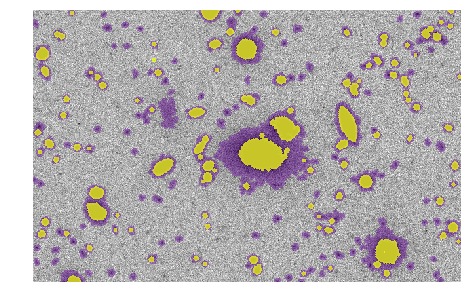

In [10]:
seg_high = fpset_high.insertIntoImage(True).getArray().copy().astype(float)
seg_low = fpset_low.insertIntoImage(True).getArray().copy().astype(float)
seg_low[seg_low>0] = 1.0
seg_low[seg_low==0] = np.nan
seg_high[seg_high>0] = 1.0
seg_high[seg_high==0] = np.nan

ax = display_image(mi.getImage().getArray())
kws = dict(cmap='plasma', vmin=0, vmax=1, origin='lower')
ax.imshow(seg_low*0.2, alpha=0.4, **kws)
ax.imshow(seg_high*1.0, alpha=0.8, **kws);

# Remove bright sources and associated diffuse light
- associate a low-thresh footprint with a high-thresh footprint if more than 5% of its light is above the high threshold

In [11]:
max_frac = 0.05

# loop over low threshold footprints 
# and save those with >max_frac high
# threshold pixels
fp_list = afwDetect.FootprintList()
for fp in fpset_low.getFootprints():
    hfp = afwDetect.HeavyFootprintF(fp, mi)
    pix = hfp.getMaskArray()
    bits_high = (pix & mask.getPlaneBitMask('HIGH_THRESH')!=0).sum()
    if bits_high/float(fp.getArea()) > max_frac:
        fp_list.append(fp)

# build a new footprint set
fpset_replace = afwDetect.FootprintSet(mi.getBBox())
fpset_replace.setFootprints(fp_list)

# create a mask plane for "cleaned" footprints
if 'CLEANED' in mask.getMaskPlaneDict().keys():
    mask.clearMaskPlane(mask.getMaskPlane('CLEANED'))
mask.addMaskPlane('CLEANED')
fpset_replace.setMask(mask, 'CLEANED')

- replace footprints associated with bright sources with sky noise

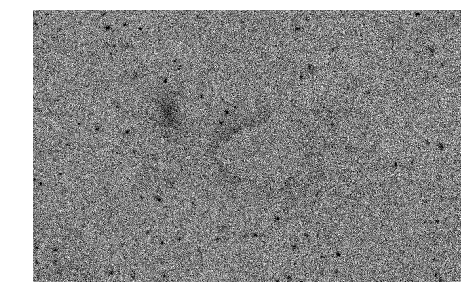

In [12]:
exp_clean = exp_cutout.clone()
mi_clean = exp_clean.getMaskedImage()
back_rms = mi.getImage().getArray()[mask.getArray()==0].std()
noise_array = back_rms*np.random.randn(*mask.getArray().shape)
replace = mask.getArray() & mask.getPlaneBitMask('BRIGHT_OBJECT') != 0
replace |= mask.getArray() & mask.getPlaneBitMask('CLEANED') != 0
mi_clean.getImage().getArray()[replace] = noise_array[replace]
display_image(mi_clean.getImage().getArray());

- smooth to emphasize extended low-surface-brightness structures

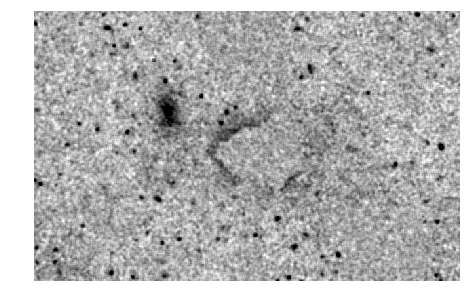

In [13]:
smoothed = smooth_gauss(mi_clean, 4)
display_image(smoothed.getImage().getArray());

### Plot using a display-agnostic display tool

We use ds9 by default, but I have experimental ginga and firefly ones too; I should write or steal one for matplotlib

In [14]:
import lsst.afw.display as afwDisplay

disp0 = afwDisplay.Display(0)

disp0.mtv(mi)